#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [ ]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

**What happens to vary the ENCODING_DIM?**

When we test the encoding dimension and change it to higher values, we see that training error decreases, and the test error converges toward the training error where, with lower encoding dimensions, we see that both errors increase and they start to have more different results.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

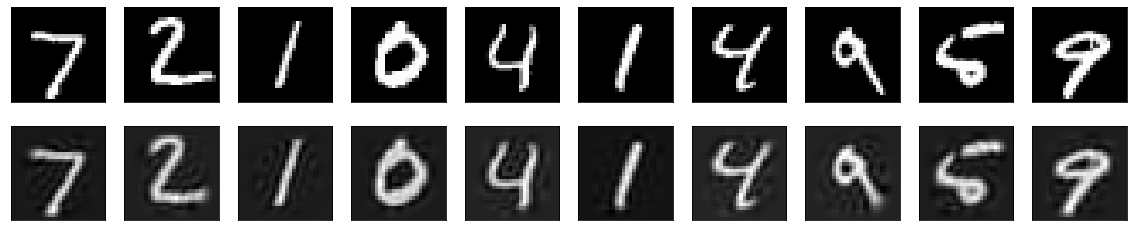

In [ ]:
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_39 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_40 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 8ms/step - loss: 0.0831 - val_loss: 0.0143
Epoch 2/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0128 - val_loss: 0.0089
Epoch 3/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 11/15
98/98 [



Comparing Results between shallow auto encoder and SVD

Shallow auto encoder with higher encoding dimension has higher training time.
We have less error in both validation and training in svd than our neural layer, unless we lower the encoding dimension to very low numbers.
Our conclusion however remains the same that SVDs perform faster and better than shallow auto encoders.

---


**Explanation of the relation between the results obtained by the shallow linear autoencoder and the ones obtained by the SVD decomposition**

In principle, both models follow the same procedure, and they are doing the same principal component analysis. Encoding the input in a lower dimension and decoding it again in the original dimension. Linear auto encoder only does this by a neural network rather than a conventional matrix multiplication.



Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00477


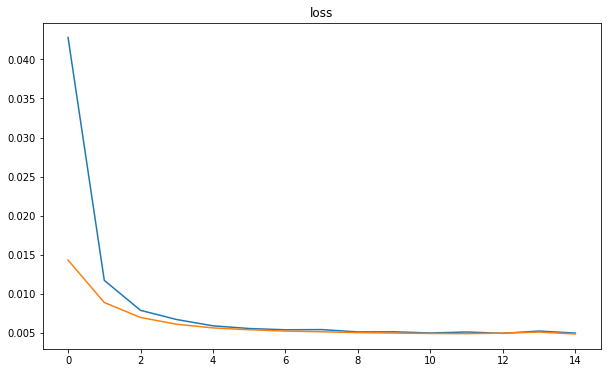

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

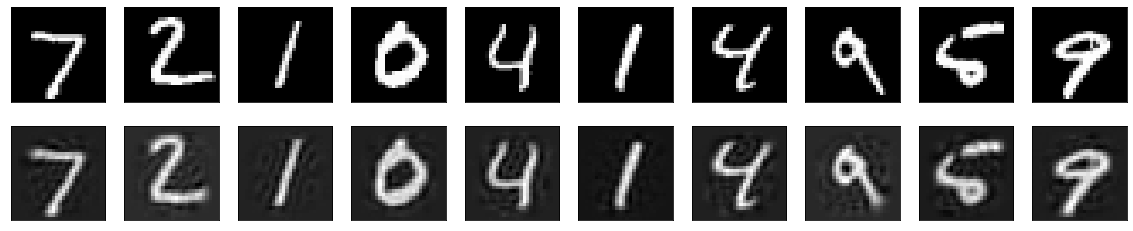

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.1 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1. (Insert your code and  theoretical discussion into  cells immediately below this one.)


**Non-linear activation functions:**

We use a for loop to search through the best non-linear activation functions. The activation function list we use is ['tanh', 'sigmoid', 'relu', 'selu', 'elu']. All of them give acceptable results except tanh, and between them, we see that sigmoid is performing slightly better than others. 
Sigmoid function even gives better results compared to the linear activation function.
Whereas tanh loss is almost double the sigmoid function.

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')
autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_41 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_42 (Dense)             (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
98/98 [==============================] - 1s 8ms/step - loss: 0.0749 - val_loss: 0.0336
Epoch 2/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0300 - val_loss: 0.0216
Epoch 3/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0200 - val_loss: 0.0156
Epoch 4/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0147 - val_los

313/313 - 0s - loss: 0.0040
test mse: 0.00398


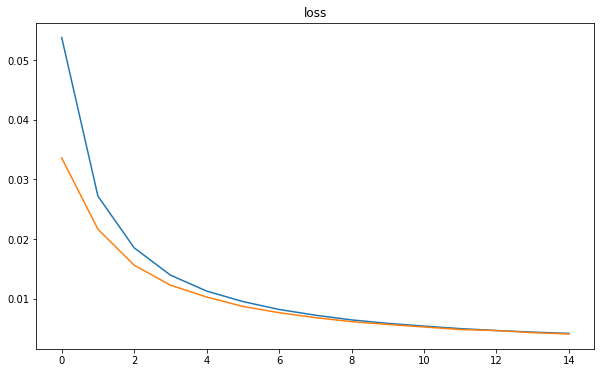

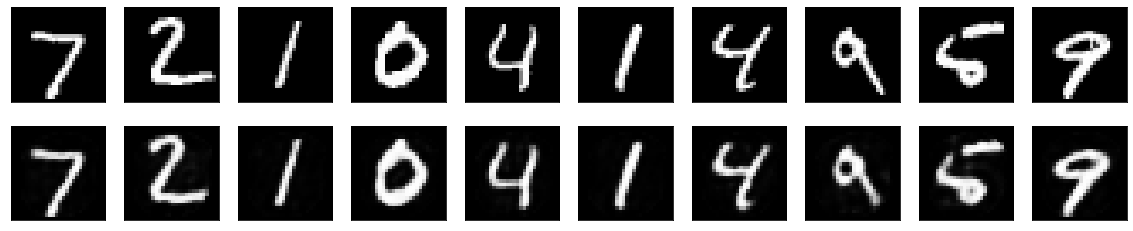

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
# Here relu activation works as the best activation function with the lowest loss,
# and we use softmax at the output layer to classify the correct class.

input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)


autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_43 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_44 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_46 (Dense)             (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 32, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
1563/1563 [==============================] - 6s 3ms/step - loss: 0.0437 - val_loss: 0.0120
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 8/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 9/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 10/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.005

313/313 - 0s - loss: 0.0045
test mse: 0.00452


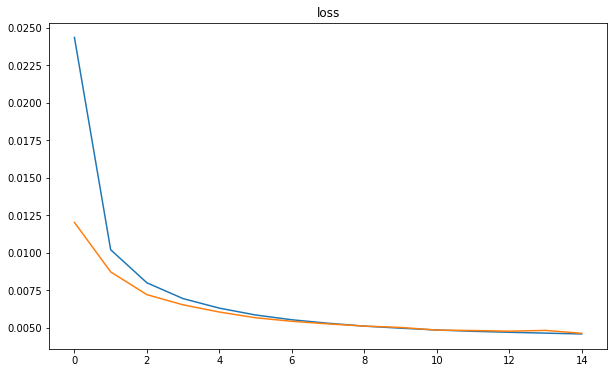

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

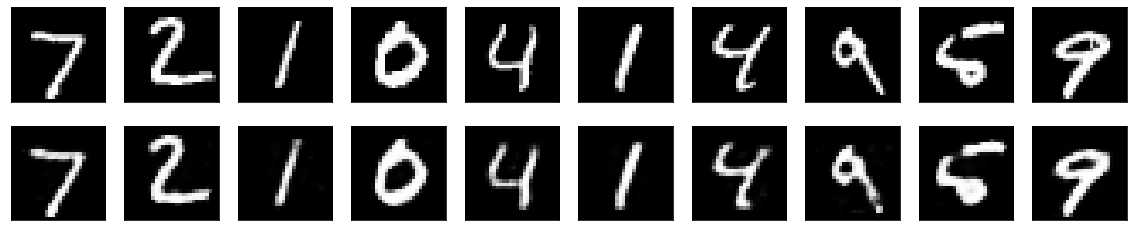

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

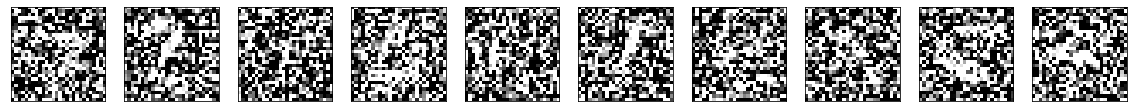

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
#[TO COMPLETE]
input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_47 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_48 (Dense)             (None, 784)               201488    
Total params: 402,448
Trainable params: 402,448
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid))#[TO COMPLETE]

Epoch 1/15
391/391 [==============================] - 2s 4ms/step - loss: 0.2963 - val_loss: 0.2333
Epoch 2/15
391/391 [==============================] - 2s 4ms/step - loss: 0.2257 - val_loss: 0.2076
Epoch 3/15
391/391 [==============================] - 2s 4ms/step - loss: 0.2043 - val_loss: 0.1946
Epoch 4/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1922 - val_loss: 0.1865
Epoch 5/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1843 - val_loss: 0.1809
Epoch 6/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1786 - val_loss: 0.1769
Epoch 7/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1742 - val_loss: 0.1742
Epoch 8/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1707 - val_loss: 0.1723
Epoch 9/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1688 - val_loss: 0.1708
Epoch 10/15
391/391 [==============================] - 2s 4ms/step - loss: 0.1667 - val_loss: 0.1698

313/313 - 0s - loss: 0.1659
test mse: 0.16590


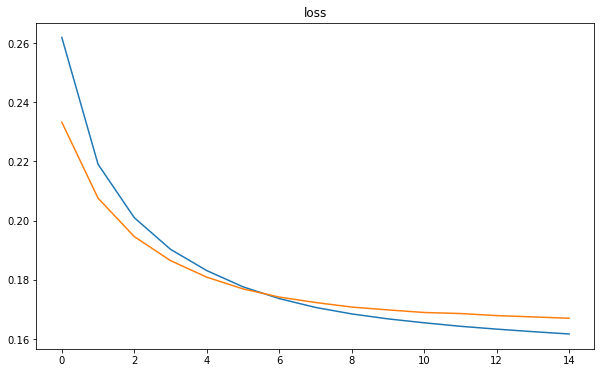

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

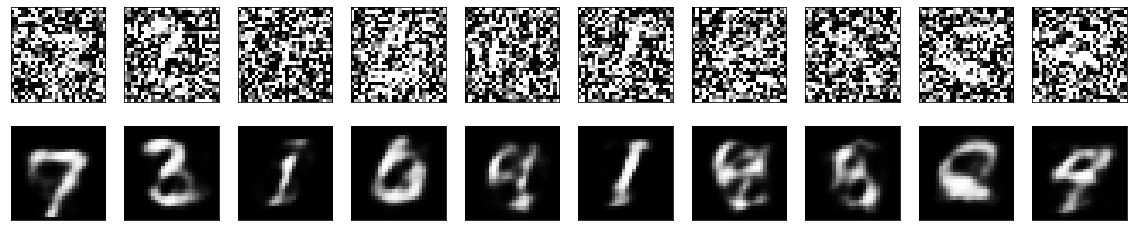

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 90, 50)            7550      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 85ms/step - loss: 0.2756 - categorical_accuracy: 0.0724 - val_loss: 0.0765 - val_categorical_accuracy: 0.4164
Epoch 2/50
79/79 [==============================] - 6s 81ms/step - loss: 0.0669 - categorical_accuracy: 0.4729 - val_loss: 0.0534 - val_categorical_accuracy: 0.5227
Epoch 3/50
79/79 [==============================] - 6s 79ms/step - loss: 0.0496 - categorical_accuracy: 0.5429 - val_loss: 0.0432 - val_categorical_accuracy: 0.5689
Epoch 4/50
79/79 [==============================] - 7s 83ms/step - loss: 0.0404 - categorical_accuracy: 0.5856 - val_loss: 0.0360 - val_categorical_accuracy: 0.5942
Epoch 5/50
79/79 [==============================] - 6s 81ms/step - loss: 0.0340 - categorical_accuracy: 0.6168 - val_loss: 0.0323 - val_categorical_accuracy: 0.6714
Epoch 6/50
79/79 [==============================] - 6s 78ms/step - loss: 0.0301 - categorical_accuracy: 0.6752 - val_loss: 0.0278 - val_categorical_accuracy: 0.6732
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0089 - categorical_accuracy: 0.9465
categorical_accuracy: 94.65%


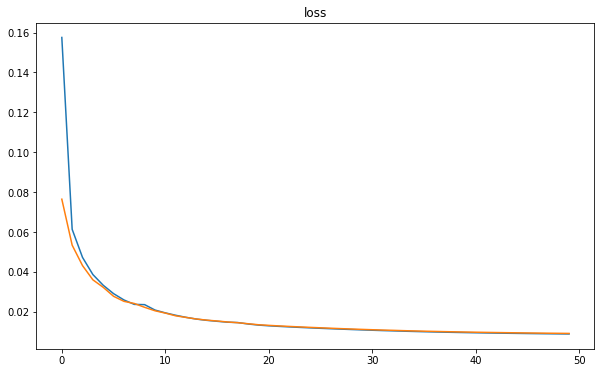

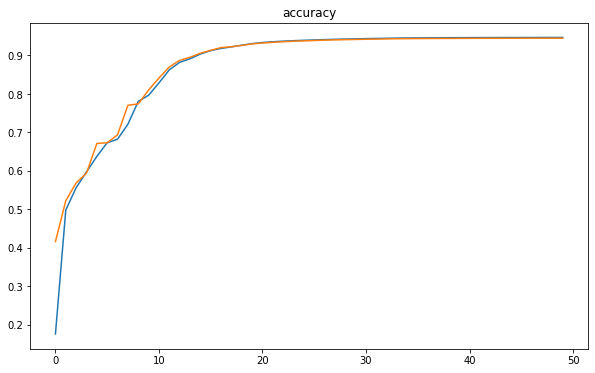

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
about a <oov> <oov> that for <oov> in all of that get but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some the <oov> have <oov> out it <oov> like <oov> <oov> of the film or <oov> <oov> there <oov> i <oov> <oov> <oov> or <oov> <oov> in the <oov> <oov> this is a great bad film that <oov> <oov> <oov> the would <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

By experimenting with a for loop:
In the decoding layer, we can see that the results of the tanh activation function are always better than other functions.
Using a tanh activation for the output layer and a linear one for the LSTM layer, we get 96% validation accuracy. Then we start experimenting with other functions for LSTM by applying a tanh function, which gives better results than a linear one, around 97%, sigmoid has very low accuracy, less than 20%, and ReLu performs even worse. In conclusion, tanh has the best performance for this type of input.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='tanh'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True,
                                   validation_data=(X_valid_one_hot, X_valid_one_hot))


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 5s 38ms/step - loss: 0.0600 - categorical_accuracy: 0.3203 - val_loss: 0.0337 - val_categorical_accuracy: 0.4959
Epoch 2/50
79/79 [==============================] - 2s 31ms/step - loss: 0.0316 - categorical_accuracy: 0.5043 - val_loss: 0.0285 - val_categorical_accuracy: 0.5003
Epoch 3/50
79/79 [==============================] - 3s

40/40 - 0s - loss: 0.0084 - categorical_accuracy: 0.9466
categorical_accuracy: 94.66%


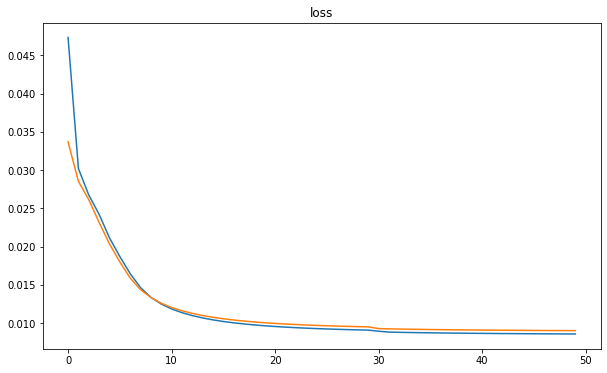

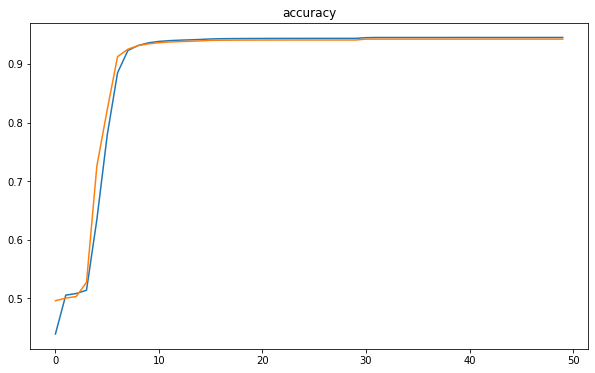

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
to a <oov> <oov> that <oov> <oov> in this of that <oov> but that <oov> the <oov> is <oov> a <oov> <oov> film in just about <oov> <oov> <oov> <oov> as <oov> other <oov> have <oov> out it <oov> like <oov> <oov> of the film <oov> <oov> <oov> there <oov> other <oov> <oov> <oov> i <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> <oov> <oov> <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> <oov> <oov>
